<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-forex/blob/main/ES_FX_Cap%C3%ADtulo_05_Estrategias_avanzadas_para_Forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>

# Estrategias avanzadas para Forex



<br>

💰 Únete a la comunidad de [Discord](https://discord.gg/z3dx5XpkX4)

📚 Puedes leer nuestro libro en [Amazon](https://www.amazon.es/Python-para-finanzas-trading-algor%C3%ADtmico-ebook/dp/B0BT4ZS9Q3/)

🖥️ El canal de [YouTube de Quantreo's](https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw) (en inglés) y el de [Frogames](https://www.youtube.com/channel/UCMUxXNYrVCv6-bQakhomvBg) en español


In [5]:
!pip install ta
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import numpy as np
import pandas as pd
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

In [7]:
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

In [8]:
namelist = ["AUDCAD", "AUDUSD", "EURGBP", "EURUSD",
            "GBPUSD", "USDCAD", "USDCHF", "USDCNH", "USDJPY"]

In [9]:
import ta
def svm_reg_trading(name, train=False):

  def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Create the SMAs
    df_indicators = ta.add_all_ta_features(
    df, open="open", high="high", low="low", close="close", volume="volume", fillna=True).shift(1)
    
    dfc = pd.concat((df_indicators, df_copy), axis=1)

    return dfc.dropna()
  
  def preprocessing(name):
  
    # Import the data
    df = pd.read_csv(name, delimiter="\t", index_col="<DATE>", parse_dates=True)

    # Delete the two last columns
    df = df.iloc[:,:-2]

    # Rename
    df.columns = ["open", "high", "low", "close", "volume"]
    df.index.name = "time"

    return df

  df = preprocessing(name)

  # Import the data
  dfc = feature_engineering(df)

  # Percentage train set
  split = int(0.80*len(dfc))

  # Train set creation
  X_train = dfc.iloc[:split,6:dfc.shape[1]-6]
  y_train = dfc[["returns"]].iloc[:split]


  # Test set creation
  X_test = dfc.iloc[split:,6:dfc.shape[1]-6]
  y_test = dfc[["returns"]].iloc[split:]


  # What you need to remind about this chapter
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()

  X_train_sc = sc.fit_transform(X_train)
  X_test_sc = sc.transform(X_test)


  from sklearn.decomposition import PCA
  pca = PCA(n_components=6)
  X_train_pca = pca.fit_transform(X_train_sc)
  X_test_pca = pca.transform(X_test_sc)

  # Import the class
  from sklearn.svm import SVR

  # Initialize the class
  reg = SVR(kernel="rbf", epsilon=0.005)

  # Fit the model
  reg.fit(X_train_pca, y_train)

  # Create predictions for the whole dataset
  X = np.concatenate((X_train_pca, X_test_pca), axis=0)

  dfc["prediction"] = reg.predict(X)

  # Compute the position
  dfc["position"] = np.sign(dfc["prediction"])

  # Compute the returns
  dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)

  dfc["return"] = dfc["strategy"]

  if train:
    return dfc["return"].iloc[:split]
  else:
    return dfc["return"].iloc[split:]

In [10]:
def BackTest(serie, annualiazed_scalar=252):
  global serie_print

  # FUNCTION TO BUT THE RIGHT DATE FORMAT
  def date_format(df):
    df.index.name = "date_time"
    df = df.reset_index(drop=False)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['date_time'] = df['date_time'].dt.date
    df = df.set_index('date_time')

    return df

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  try:
    # Concat the returns and the sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

  except:
    # Put the right date format
    sp500 = date_format(sp500)
    serie = date_format(serie)

    # Concat the returns and the sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

  # Compute the drawdown
  drawdown = drawdown_function(serie)*100
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown.values.flatten(), color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plot the graph
  plt.show()

  try:
    serie = serie["return"]
  except:
    pass
  
  serie_print = serie
  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  try:
    print(f"MaxDrawdown: {np.round(max_drawdown[0],3)} %")
  except:
    print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

# Aplicación

In [13]:
svm_reg_trading("/content/USDJPY_D1.csv")

time
2019-10-31   -0.007662
2019-11-01    0.001389
2019-11-04    0.003726
2019-11-05    0.005259
2019-11-06   -0.001640
                ...   
2022-01-10   -0.003012
2022-01-11    0.000747
2022-01-12   -0.005725
2022-01-13   -0.003995
2022-01-14    0.000236
Name: return, Length: 573, dtype: float64

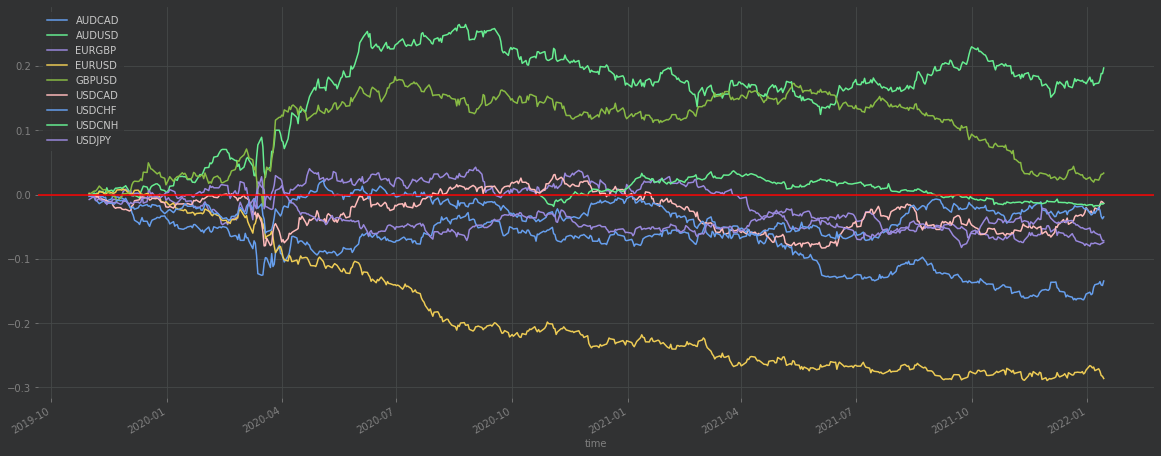

In [14]:
namelist = ["AUDCAD", "AUDUSD", "EURGBP", "EURUSD",
            "GBPUSD", "USDCAD", "USDCHF", "USDCNH", "USDJPY"]

# Create empty dataframe
dft = pd.DataFrame()

for name in namelist:

  # Create the strategy
  dfc = svm_reg_trading(f"{name}_D1.csv")
  
  # Rename return
  dfc.rename = name

  # drop the nan
  dft[name] = dfc.fillna(value=0)-0.0001

dft.cumsum().plot(figsize=(20,8))
plt.axhline(0, color="red")

In [15]:
dft.to_csv("ML.csv")

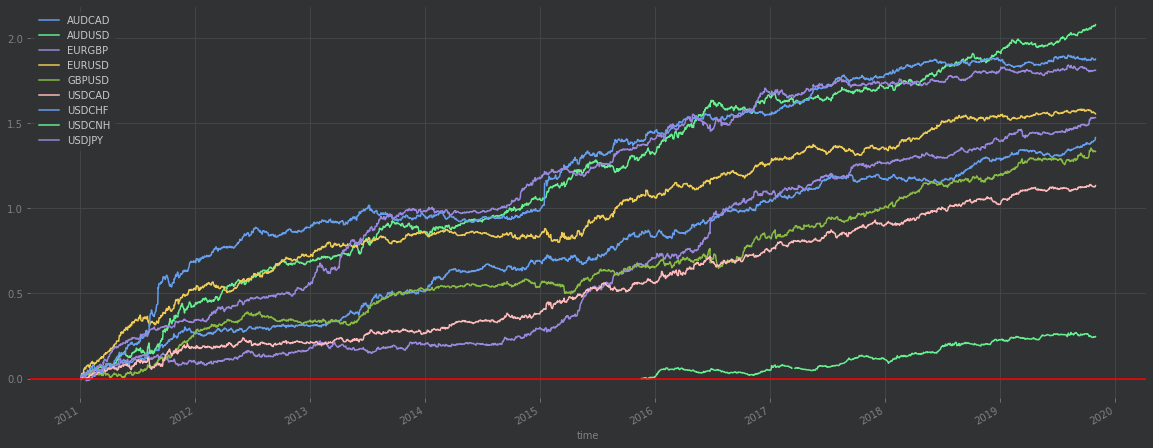

In [ ]:
namelist = ["AUDCAD", "AUDUSD", "EURGBP", "EURUSD",
            "GBPUSD", "USDCAD", "USDCHF", "USDCNH", "USDJPY"]

# Create empty dataframe
dft = pd.DataFrame()

for name in namelist:

  # Create the strategy
  dfc = svm_reg_trading(f"{name}_D1.csv", train=True)
  
  # Rename return
  dfc.rename = name

  # drop the nan
  dft[name] = dfc.fillna(value=0)-0.0001

dft.cumsum().plot(figsize=(20,8))
plt.axhline(0, color="red")